In [1]:
import matplotlib as mpl
mpl.rcParams.update({'font.size': 12})
mpl.rcParams['axes.formatter.useoffset'] = False

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np


In [2]:
import utils.load_grid as lg
from utils.load_cmaps import *

In [3]:
pgrid_dir = "data/shared/hd63433d_v5"
cases = lg.get_cases(pgrid_dir)

In [4]:
# Collect netcdf files
stts = lg.get_statuses(pgrid_dir)
# endn = lg.load_netcdfs_end(cases)

# Configuration variables
cvars = lg.load_cvars(cases)

# Helpfiles
helps, hvars = lg.load_helpfiles(cases)

print("Done")

Helpfiles: 100%|██████████| 22/22 [00:00<00:00, 106.88it/s]


Done


In [5]:
# %matplotlib widget
%matplotlib inline

### Plot mixing ratio as bar chart for each species, along one variable axis

In [18]:
def make_bars_by_species(x,x_lbl, control, plot_controls=False, legend=True):
    # Make plot
    x_plt = np.array([], dtype=float) # x variable
    c_plt = np.array([], dtype=int)   # case number
    g_plt = np.array([], dtype=bool)  # case finished with success? (good)
    g_plt = np.array([], dtype=bool)  # case finished with failure? (bad)
    for i in range(len(x)):
        skip_this = False
        for k in control.keys():
            if k in cvars.keys():
                if not np.isclose(cvars[k][i],control[k]):
                    skip_this = True
                    break
        if skip_this:
            continue
        x_plt = np.append(x_plt, x[i])
        c_plt = np.append(c_plt, i)
        g_plt = np.append(g_plt, bool( 10 <= stts[i] <= 19))
    if len(x_plt) == 0:
        print("WARNING: No data left after applying control variables!")
        return

    sort_mask = np.argsort(x_plt)
    x_plt = x_plt[sort_mask]
    c_plt = c_plt[sort_mask]
    g_plt = g_plt[sort_mask]

    fig,ax = plt.subplots(1,1, figsize=(7,5))

    present = np.full(len(lg.volatile_species), False)
    for j,v in enumerate(lg.volatile_species):
        for i in range(len(x_plt)):
            r = lg.access_hvars(hvars,v+"_bar",-1)[c_plt[i]]
            if r > 1.0e-30:
                present[j] = True

    # Make each bar chart
    norm = mpl.colors.Normalize(vmin=x_plt[0], vmax=x_plt[-1])
    sm = plt.cm.ScalarMappable(cmap=sci_colormaps['batlowK_r'], norm=norm)
    sm.set_array([])

    # Initial
    offset = 1/np.count_nonzero(present)
    gap = 1.5
    for i in range(len(x_plt)):
        ratios = []
        names  = []
        for j,v in enumerate(lg.volatile_species):
            if not present[j]:
                continue
            r = lg.access_hvars(hvars,v+"_bar",5)[c_plt[i]]
            names.append(v)
            ratios.append(r)
        x_base = np.linspace(0, len(x_plt)+gap-1, len(ratios)) + i*offset
        ax.scatter(x_base,ratios,color='#333333',marker='_', zorder=6, s=70)

    ax.set_xticks(x_base-offset*2)
    ax.set_xticklabels(names)

    # Final
    offset = 1/np.count_nonzero(present)
    gap = 1.5
    for i in range(len(x_plt)):
        ratios = []
        names  = []
        for j,v in enumerate(lg.volatile_species):
            if not present[j]:
                continue
            r = lg.access_hvars(hvars,v+"_bar",-1)[c_plt[i]]
            names.append(v)
            ratios.append(r)
        x_base = np.linspace(0, len(x_plt)+gap-1, len(ratios)) + i*offset
        c = sm.to_rgba(x_plt[i])
        l = "%g"%x_plt[i]
        ax.bar(x_base,ratios, width=offset, label=l, color=c, zorder=3)

    if plot_controls:
        control_str = "Control variables:\n"
        for k in control.keys():
            control_str += "  %s=%g\n" % (k,control[k])
        control_str = control_str[:-1]
        axt = ax.text(0.05, 0.95, control_str,
                horizontalalignment='left', verticalalignment='top', transform=ax.transAxes, fontsize=10)
        axt.set_bbox(dict(facecolor='white', alpha=0.5, linewidth=0))

    # ax.set_xlabel("Species")
    ax.set_ylabel("Partial pressure [bar]")
    ax.set_yscale("log")
    ax.set_ylim(bottom=1e-4)
    if legend:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title=x_lbl)
    ax.grid(axis='y', zorder=1)

    fig.savefig("output/recent_composition-bars.pdf", bbox_inches='tight')
    plt.show()

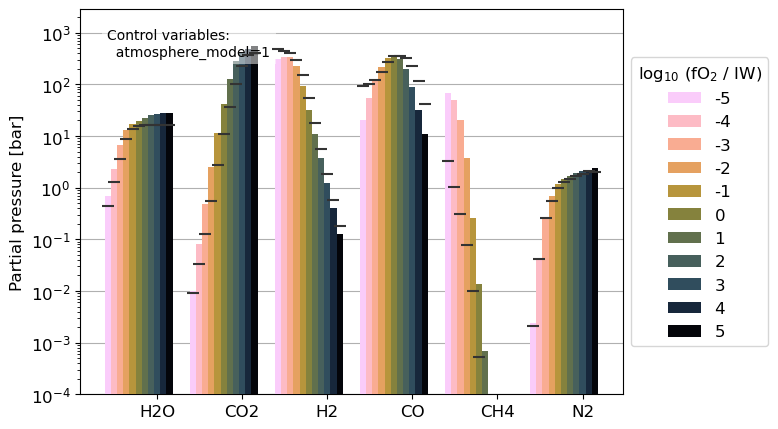

In [19]:
# Variables
x = cvars["fO2_shift_IW"];  x_lbl = "log$_{10}$ (fO$_{2}$ / IW)"
# control = {"mean_distance":1.0, "CH_ratio":2.0, "hydrogen_earth_oceans":10.0}
control = {"atmosphere_model":1}

plot_controls = True
make_bars_by_species(x,x_lbl,control, plot_controls=plot_controls)


### Plot mixing ratio (for all species), along one variable axis, as a stacked chart

In [15]:
def make_bars_by_axis(x,x_lbl, control, plot_controls=False):
    # Make plot
    x_plt = np.array([], dtype=float) # x variable
    c_plt = np.array([], dtype=int)   # case number
    g_plt = np.array([], dtype=bool)  # case finished with success? (good)
    g_plt = np.array([], dtype=bool)  # case finished with failure? (bad)
    for i in range(len(x)):
        skip_this = False
        for k in control.keys():
            if k in cvars.keys():
                if not np.isclose(cvars[k][i],control[k]):
                    skip_this = True
                    break
        if skip_this:
            continue
        x_plt = np.append(x_plt, x[i])
        c_plt = np.append(c_plt, i)
        g_plt = np.append(g_plt, bool( 10 <= stts[i] <= 19))
    if len(x_plt) == 0:
        print("WARNING: No data left after applying control variables!")
        return

    fig,ax = plt.subplots(1,1, figsize=(5,5))

    present = np.full(len(lg.volatile_species), False)
    for j,v in enumerate(lg.volatile_species):
        for i in range(len(x_plt)):
            r = lg.access_hvars(hvars,v+"_atm_bar",-1)[c_plt[i]]
            if r > 1.0e-30:
                present[j] = True

    # Make bar charts
    vmr_last = np.zeros(len(x_plt))
    for j,v in enumerate(lg.volatile_species[:3]):
        if not present[j]:
            continue
        vmr = []
        for i in range(len(x_plt)):
            vmr.append(lg.access_hvars(hvars,v+"_atm_bar",-1)[c_plt[i]])
        ax.bar(x_plt, vmr, bottom=vmr_last, color=lg.volatile_colors[v], label=v)
        vmr_last += vmr

    if plot_controls:
        control_str = "Control variables:\n"
        for k in control.keys():
            control_str += "  %s=%g\n" % (k,control[k])
        control_str = control_str[:-1]
        axt = ax.text(0.05, 0.95, control_str,
                horizontalalignment='left', verticalalignment='top', transform=ax.transAxes, fontsize=10)
        axt.set_bbox(dict(facecolor='white', alpha=0.5, linewidth=0))

    ax.set_xlabel(x_lbl)
    ax.set_ylabel("Partial pressure [bar]")
    # ax.set_yscale("log")

    # Legend
    patches = []
    for j,v in enumerate(lg.volatile_species):
        if present[j]:
            patches.append(mpatches.Patch(color=lg.volatile_colors[v], label=v))
    ax.legend(handles=patches,loc='center left', bbox_to_anchor=(1, 0.5), title="Species")

    plt.show()

In [16]:
# Variables
x = cvars["fO2_shift_IW"];  x_lbl = "log10 fO2 - IW"
control = {"mean_distance":1.0, "CH_ratio":0.1}

plot_controls = True

make_bars_by_axis(x,x_lbl,control, plot_controls=plot_controls)
